# Choice Set space for Neural Data

 The idea is to create a choice set that: samples the same SV difference (+ - some variation) with different trials.
 - 5 different SV deltas, including 0.   

In [69]:
#Import the relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 999
#pd.options.display.max_columns = 999

# 1. Input: 
- Patient's RAW data

- Parameters from the utility model

In [70]:
path= 'Z:\datasets\ICR' #Specify where the data is stored in the FileShare. This is for my Laptop

#Path to the data files
#path = '/Volumes/UCDN/datasets/ICR' #MAC path to the File share
patient_code = 'patient1_calibration' #Specify the patient's code
patient_split_dir = os.path.join(path,'split') 
patient_trials = os.path.join(patient_split_dir,'{}/crdm/{}_crdm.csv').format(patient_code,patient_code) #This is the psychopy output CSV

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis.csv')
parameters = pd.read_csv(utility_analysis)

print('loading fn: {}'.format(patient_trials))
print('loading fn: {}'.format(utility_analysis))

loading fn: Z:\datasets\ICR\split\patient1_calibration/crdm/patient1_calibration_crdm.csv
loading fn: Z:\datasets\ICR\utility\split_CRDM_analysis.csv


In [71]:
#Declare the variables we are going to be using

trials = pd.read_csv(patient_trials)
p_options = trials['crdm_lott_p'].unique()/100
p_options = p_options[~np.isnan(p_options)]  # Remove nan values ~is a logical NOT operator
p_options = p_options.tolist()  # Do we want p_options to be an array or a list? Ask Ricardo 
p_options = sorted(p_options, reverse=True)
amb_options = [0.24, 0.5, 0.74]

#Declare the variables


# A= df['crdm_amb_lev'].values[0] #Ambiguity level
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
Vsafe_pos = 5.0 # The old safe option in positive trials
Vsafe_neg = -5.0 # The old safe option in negative trials

# used for populating trials
empty_df = pd.DataFrame([],columns=['category','p_reward', 'value_reward'])

p_options 


[0.75, 0.5, 0.38, 0.25, 0.13]

# 2. Running the model and plotting it

In [72]:

#From the CRDM_analysis CSV we pick our patient's parameters
filtered_parameters = parameters[parameters['subject'] == patient_code]

# Create pos, comb, neg parameters and read them from the csv
alpha_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'alpha'].values[0]
#alpha_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'alpha'].values[0]
alpha_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'alpha'].values[0]


beta_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'beta'].values[0]
#beta_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'beta'].values[0]
beta_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'beta'].values[0]


print("alpha_pos:", alpha_pos)
#print("alpha_combined:", alpha_comb)
print("alpha_neg:", alpha_neg)

print("\nbeta_pos:", beta_pos)
#print("beta_combined:", beta_comb)
print("beta_neg:", beta_neg)



alpha_pos: 1.6072504874601523
alpha_neg: 0.4170717439476477

beta_pos: 1.5054630816531134
beta_neg: -0.4560219365565699


In [73]:
def plot_sv(alpha, beta, trials = 'gains'): #Define a function to plot SV given participant's input
    A = 0 
    p_options = [1.0, 0.87, 0.75, 0.62, 0.5, 0.38, 0.25, 0.13] #We want a line for every probability level. The 1.0 is the classic (non risky) utility function
    
    v = np.linspace(0, 50, 100) # The x axis goes from 0 to 50 an takes 100 points (just to make the figure smooth
    if trials == 'losses':
        v = np.linspace(0, -50, 100)
    plt.figure(figsize=(10, 6)) #Create a plot figure
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    for p in p_options: #Iterate through each probability level
        sv = (p - beta * A / 2)* Amp * abs(v)**alpha #Calculate the SV of every V from 0 to 50 for a given p
        if p == 1.0:  #Non risky 
            plt.plot(v, sv, label=f'p = {p}', linestyle='--', color='black') #If p=0, plot a black dashed line using V as X and SV as Y
        else:
            plt.plot(v, sv, label=f'p = {p}')

    plt.xlabel('Value of Reward')
    plt.ylabel('SV')
    plt.title("Participant's SV model for {}".format(trials))
    plt.legend()
    plt.grid(True)
    plt.show()



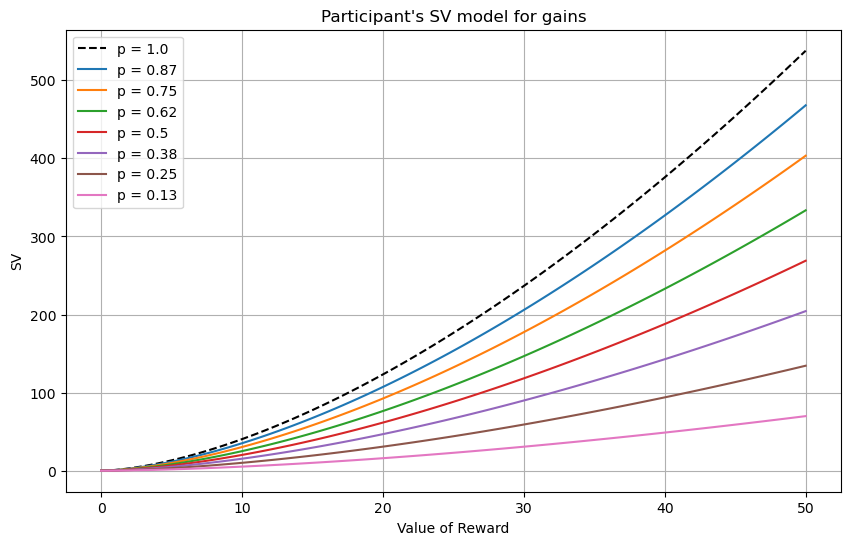

In [74]:
plot_sv(alpha_pos,beta_pos, trials = 'gains')

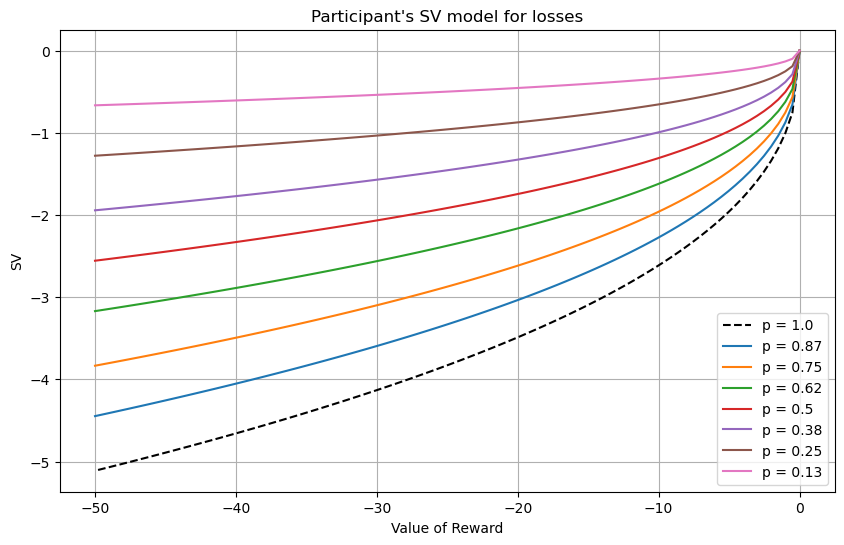

In [75]:
plot_sv(alpha_neg,beta_neg, trials = 'losses')

# 3. Creating the choice set

- 5 different SV deltas, including 0.
- Max SV delta
    - Winning or loosing $50 for each probability level
    - 


- Min SV delta: subjective equality trials. 

- 3 Intermediate trials. 


In [76]:
#Create the extreme positive gains and losses

def get_extreme(p_options,trials='gains'):
    extr = {} #Create an empty dict
    V = Vmax
    if trials=='losses': #If trials are losses, assign them -50
        V = Vmin
    for p in p_options: #Iterate through the probability levels
        extr[p] = V #Assign them the 50 dollars value
    return extr

extrpos = get_extreme(p_options)

extrneg = get_extreme(p_options,trials='losses')

#From the dictionaries, we create DataFrames to work with
def get_extr_df(extr_dict,trials='gains'):
    df_app = pd.DataFrame(extr_dict.items(), columns=['p_reward', 'value_reward'])
    Extr_df = pd.concat([empty_df, df_app], ignore_index=True)
    category = 'Extr_pos'
    if trials=='losses':
        category = 'Extr_neg'
    Extr_df['category'] = category
    Extr_df['ambiguity'] = A_null
    return Extr_df

def add_ambig_extr(df,amb_options,Vmax=50,prob_amb=0.50,trials='gains'):
    amb_dict = {prob_amb:amb_options}
    df_app = pd.DataFrame(amb_dict.items(), columns=['p_reward', 'ambiguity'])
    df_app = df_app.explode('ambiguity')
    df_app['category'] = df['category']
    df_app['value_reward'] = Vmax
    df = pd.concat([df,df_app],ignore_index=True)
    return df

# df_app = pd.DataFrame(centrials_neg.items(), columns=['p_reward', 'value_reward'])
# df_app = df_app.explode('value_reward')


#We define a function to calculate the SV of the trials given the 
#participant's alpha and beta

def append_SVreward(df,alpha,beta,trials='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_reward'] = (df['p_reward'] - beta*df['ambiguity']/2)*Amp*(abs(df['value_reward']))**alpha
    return df

#We define a function to calculate the SV of the safe options of the trials given the 
#participant's alpha and beta

def append_Vsafe(df,alpha,beta,trials='gains'): 
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_New_Safe'] = 0.5*df['SV_reward']
    df['value_lott_SE'] = Amp*(abs(df['SV_New_Safe']) / (df['p_reward']-beta*df['ambiguity']/2)) ** (1 / alpha)
    df['value_safe'] = Amp*(abs(df['SV_New_Safe'])) ** (1 / alpha)
    return df

#Define the data frames
df_pos = get_extr_df(extrpos)
df_pos = add_ambig_extr(df_pos,amb_options)

df_neg = get_extr_df(extrneg,trials='losses')
df_neg = add_ambig_extr(df_neg,amb_options,Vmax=Vmin,trials='losses')


#Add the SV of reward and safe trials
df_pos = append_SVreward(df_pos,alpha_pos,beta_pos)
df_neg = append_SVreward(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos = append_Vsafe(df_pos,alpha_pos,beta_pos)
df_neg = append_Vsafe(df_neg,alpha_neg,beta_neg,trials='losses')


In [77]:
# Safe option dataframe to use when merging multiple dataframes
df_safe_pos = df_pos[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()
df_safe_neg = df_neg[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()

#Define the trials of subjective equality

#For gains
df_SE_pos = df_pos[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_pos['category'] = 'SE_pos'
df_SE_pos = df_SE_pos.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_pos['value_safe'] = df_safe_pos['value_safe']
df_SE_pos = df_SE_pos.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

#For losses
df_SE_neg = df_neg[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_neg['category'] = 'SE_neg'
df_SE_neg = df_SE_neg.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_neg['value_safe'] = df_safe_neg['value_safe']
df_SE_neg = df_SE_neg.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

#Centered around SE

#For gains
df_cent_pos= df_SE_pos.copy()

df_cent_pos['category'] = 'Cent_SE_pos'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df_adjusted_pos = df_cent_pos.copy()
df_adjusted_pos['value_reward'] = df_adjusted_pos['value_reward'] +2.0

df_adjusted_neg = df_cent_pos.copy()
df_adjusted_neg['value_reward'] = df_adjusted_neg['value_reward'] - 2.0
df_cent_pos = pd.concat([df_cent_pos, df_adjusted_pos, df_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
df_cent_pos = df_cent_pos.round(2)

#For losses
#For gains
df_cent_neg= df_SE_neg.copy()

df_cent_neg['category'] = 'Cent_SE_neg'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df1_adjusted_pos = df_cent_neg.copy()
df1_adjusted_pos['value_reward'] = df1_adjusted_pos['value_reward'] +2.0

df1_adjusted_neg = df_cent_neg.copy()
df1_adjusted_neg['value_reward'] = df1_adjusted_neg['value_reward'] - 2.0
df_cent_neg = pd.concat([df_cent_neg, df1_adjusted_pos, df1_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_neg = append_SVreward(df_cent_neg,alpha_neg,beta_neg,trials='losses')


In [78]:
df_pos = df_pos.sort_values('SV_reward', ascending=False).reset_index(drop=True)
df_neg = df_neg.sort_values('SV_reward', ascending=True).reset_index(drop=True)

In [79]:
#Selecting ourg SVdiff sampling. We are doing this by ojo of which SVdiff allows more sampling.
#We need to create a more systematic method. 

#For Gains
df_pos = df_pos.sort_values('SV_reward', ascending=False).reset_index(drop=True)
# fourth ranked SV_reward
index = 3
# SV_reward
col = 4
SV_max_pos = df_pos.iloc[index,col]
_SV_safe = df_pos.iloc[index,col+1]
# sampling here
_delta_SV = SV_max_pos - _SV_safe
# second sampling
_delta_SV2 = 0.5 * _delta_SV
print(SV_max_pos,_SV_safe,_delta_SV,_delta_SV2)

#For Losses

# fourth ranked SV_reward
neg_index = 4
# SV_reward
neg_col = 4
SV_min_neg = df_neg.iloc[neg_index,neg_col]
neg_SV_safe = df_neg.iloc[neg_index,neg_col+1]
# sampling here
neg_delta_SV = SV_min_neg - neg_SV_safe
# second sampling
neg_delta_SV2 = 0.5 * neg_delta_SV



171.7630382354947 85.88151911774735 85.88151911774735 42.94075955887367


In [80]:
#Creating the Neg target SVdeltas and SV_rewards
neg_df1 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df1['category'] = 'MaxSVdelta_Loss'
neg_df1['deltaSV'] = neg_delta_SV
neg_df1['SV_reward'] = neg_df1['deltaSV'] + neg_df1['SV_New_Safe']
#new_df1

neg_df2 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df2['category'] = 'Neg_Half_maxSV_delta'
neg_df2['deltaSV'] = neg_delta_SV2
neg_df2['SV_reward'] = neg_df2['deltaSV'] + neg_df2['SV_New_Safe']
neg_df2

#neg_df3 = pd.concat([neg_df1,neg_df2], ignore_index=True)

neg_df3 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df3['category'] = 'MinSVdelta'
neg_df3['deltaSV'] = -1.0*neg_delta_SV
neg_df3['SV_reward'] = neg_df3['deltaSV'] + neg_df3['SV_New_Safe']


neg_df4 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df4['category'] = 'Neg_Half_minSV_delta'
neg_df4['deltaSV'] = -1.0*neg_delta_SV2
neg_df4['SV_reward'] = neg_df4['deltaSV'] + neg_df4['SV_New_Safe']
#new_df4 = pd.concat([min_df1,min_df2], ignore_index=True)
neg_df = pd.concat([neg_df1,neg_df2,neg_df3,neg_df4], ignore_index=True) 


In [81]:

#Creating the Neg target SVdeltas and SV_rewards
new_df1 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
new_df1['category'] = 'MaxSVdelta'
new_df1['deltaSV'] = _delta_SV
new_df1['SV_reward'] = new_df1['deltaSV'] + new_df1['SV_New_Safe']
#new_df1

new_df2 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
new_df2['category'] = 'half_maxSV_delta'
new_df2['deltaSV'] = _delta_SV2
new_df2['SV_reward'] = new_df2['deltaSV'] + new_df2['SV_New_Safe']
new_df3 = pd.concat([new_df1,new_df2], ignore_index=True)

min_df1 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
min_df1['category'] = 'MinSVdelta'
min_df1['deltaSV'] = -1.0*_delta_SV
min_df1['SV_reward'] = min_df1['deltaSV'] + min_df1['SV_New_Safe']


min_df2 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
min_df2['category'] = 'Half_minSV_delta'
min_df2['deltaSV'] = -1.0*_delta_SV2
min_df2['SV_reward'] = min_df2['deltaSV'] + min_df2['SV_New_Safe']
new_df4 = pd.concat([min_df1,min_df2], ignore_index=True)
new_df5 = pd.concat([new_df3, new_df4], ignore_index=True) 

In [82]:
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
#alpha_comb = 0.9555108189143096
#beta_comb = 0.617126793788233
def calculate_value_reward(df, alpha, beta):
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50
        if SV<0.0: 
            continue    
        value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta. Should we fix p to 0.5?
        if (value_reward <100) and (value_reward>=0.0):
            new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
            #All the calculated values are used to create a new dictionary for each combination.
            #The dictionaries are collected in a new rows list. 
            new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
            new_df = new_df.round(2) 
    return new_df

df_SVdeltas_gains = calculate_value_reward(new_df5, alpha_pos, beta_pos)
#df_pos1 = df_pos1.drop(columns=['SV_New_Safe'])
#df_pos1 = append_SVreward(df_pos1,alpha_comb,beta_comb)

df_SVdeltas_gains 

C:\Users\guardomayas2\AppData\Local\Temp\ipykernel_9704\2307828030.py:17: RuntimeWarning: invalid value encountered in scalar power
  value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta. Should we fix p to 0.5?
C:\Users\guardomayas2\AppData\Local\Temp\ipykernel_9704\2307828030.py:17: RuntimeWarning: invalid value encountered in scalar power
  value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta. Should we fix p to 0.5?


,category,p_reward,ambiguity,value_reward,SV_reward,value_safe
0,MaxSVdelta,0.75,0.00,40.51,287.58,27.16
1,MaxSVdelta,0.50,0.00,44.17,220.35,21.10
2,MaxSVdelta,0.38,0.00,47.48,188.08,17.79
3,MaxSVdelta,0.50,0.24,50.00,171.76,15.97
4,MaxSVdelta,0.25,0.00,54.21,153.11,13.71
5,MaxSVdelta,0.13,0.00,70.28,120.84,9.13
6,MaxSVdelta,0.50,0.50,71.86,119.13,8.85
7,half_maxSV_delta,0.75,0.00,36.63,244.64,27.16
8,half_maxSV_delta,0.50,0.00,38.60,177.41,21.10
9,half_maxSV_delta,0.38,0.00,40.41,145.13,17.79


In [83]:
''' still working in a single function
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]

def calculate_value_reward(df, alpha, beta, trials ='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50    
        value_reward = (Amp*(abs(SV)/p - beta * A / 2))**(1/alpha)
        if trials == 'gains':
            if (value_reward <100) and (value_reward>=0.0):
                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
        elif trials == 'losses':
            if (value_reward >-100) and (value_reward<=0.0):
                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
        #All the calculated values are used to create a new dictionary for each combination.
        #The dictionaries are collected in a new rows list. 
        new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
        new_df = new_df.round(2) 
    return new_df

'''


" still working in a single function\np_options = [0.75, 0.5, 0.38, 0.25, 0.13]\n\ndef calculate_value_reward(df, alpha, beta, trials ='gains'):\n    Amp = 1.0\n    if trials == 'losses':\n        Amp = -1.0\n    new_rows = []\n    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)\n                                # and extract the relevant values to calculate value_reward\n        SV = row['SV_reward']  #The SV of the given row\n        value_safe = row['value_safe'] #To keep value_safe constant\n        p= row['p_reward']\n        #value_safe = 5.0\n        A = row['ambiguity'] \n        if A!= 0:\n            p=0.50    \n        value_reward = (Amp*(abs(SV)/p - beta * A / 2))**(1/alpha)\n        if trials == 'gains':\n            if (value_reward <100) and (value_reward>=0.0):\n                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) \n  

In [84]:
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
#alpha_neg: 0.5420177337405991
#beta_neg: -1.177300190736865
def calculate_value_reward_losses(df, alpha, beta):
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50
        if SV>0.0: 
            continue    
        value_reward = -((abs(SV)/(p-beta*A/2))**(1/alpha))
        if (value_reward >-100) and (value_reward<=0.0):
            new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
            #All the calculated values are used to create a new dictionary for each combination.
            #The dictionaries are collected in a new rows list. 
            new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
            new_df = new_df.round(2) 
    return new_df

df_SVdeltas_losses =  calculate_value_reward_losses(neg_df, alpha_neg, beta_neg)


# 4. Concat the DataFrames 

In [85]:
df_Trials_gains = pd.concat([df_SVdeltas_gains, df_cent_pos],ignore_index=True)
df_Trials_gains['SV_New_Safe'] = df_Trials_gains['value_safe']**alpha_pos
df_Trials_gains['deltaSV'] = df_Trials_gains['SV_reward'] - df_Trials_gains['SV_New_Safe']
#df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward', 'deltaSV']
df_Trials_gains[columns_to_convert] = df_Trials_gains[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_gains = df_Trials_gains.round(2)
df_Trials_gains

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta,0.75,0.0,40.510000+0.000000j,287.58,27.16,201.689976,85.89
1,MaxSVdelta,0.50,0.0,44.170000+0.000000j,220.35,21.10,134.416822,85.93
2,MaxSVdelta,0.38,0.0,47.480000+0.000000j,188.08,17.79,102.175295,85.90
3,MaxSVdelta,0.50,0.24,50.000000+0.000000j,171.76,15.97,85.903807,85.86
4,MaxSVdelta,0.25,0.0,54.210000+0.000000j,153.11,13.71,67.220851,85.89
5,MaxSVdelta,0.13,0.0,70.280000+0.000000j,120.84,9.13,34.971731,85.87
6,MaxSVdelta,0.50,0.5,71.860000+0.000000j,119.13,8.85,33.264043,85.87
7,half_maxSV_delta,0.75,0.0,36.630000+0.000000j,244.64,27.16,201.689976,42.95
8,half_maxSV_delta,0.50,0.0,38.600000+0.000000j,177.41,21.10,134.416822,42.99
9,half_maxSV_delta,0.38,0.0,40.410000+0.000000j,145.13,17.79,102.175295,42.95


In [86]:
df_Trials_losses = pd.concat([df_SVdeltas_losses, df_cent_neg],ignore_index=True)
df_Trials_losses['SV_New_Safe'] = -abs(df_Trials_losses['value_safe'])**alpha_neg
df_Trials_losses['deltaSV'] = df_Trials_losses['SV_reward'] - df_Trials_losses['SV_New_Safe']
#df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward']
df_Trials_losses[columns_to_convert] = df_Trials_losses[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_losses = df_Trials_losses.round(2)
df_Trials_losses

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta_Loss,0.75,0.0,-32.29,-3.20,-4.76,-1.91695,-1.28305
1,MaxSVdelta_Loss,0.50,0.74,-36.19,-2.99,-3.62,-1.7101,-1.2799
2,MaxSVdelta_Loss,0.50,0.5,-39.58,-2.85,-2.95,-1.57018,-1.27982
3,MaxSVdelta_Loss,0.50,0.24,-44.29,-2.70,-2.31,-1.417922,-1.282078
4,MaxSVdelta_Loss,0.50,0.0,-50.00,-2.56,-1.80,-1.277812,-1.282188
5,MaxSVdelta_Loss,0.38,0.0,-71.06,-2.25,-0.93,-0.970186,-1.279814
6,Neg_Half_maxSV_delta,0.75,0.0,-18.91,-2.56,-4.76,-1.91695,-0.64305
7,Neg_Half_maxSV_delta,0.50,0.74,-20.32,-2.35,-3.62,-1.7101,-0.6399
8,Neg_Half_maxSV_delta,0.50,0.5,-21.52,-2.21,-2.95,-1.57018,-0.63982
9,Neg_Half_maxSV_delta,0.50,0.24,-23.15,-2.06,-2.31,-1.417922,-0.642078


# 5. Making sure it works. 
A.k.a Sanity check 

In [87]:
from matplotlib.gridspec import GridSpec
import sys

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','c','b','y','m','k','g']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")


c:\Users\guardomayas2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


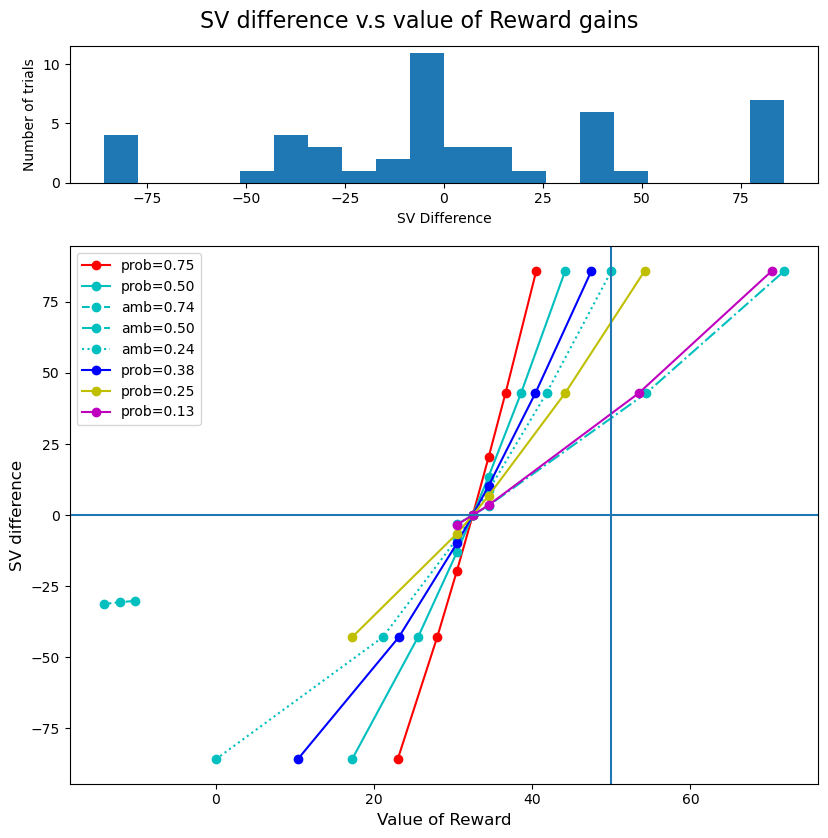

In [88]:
plot_scatter_hist(df_Trials_gains,xvline=50)

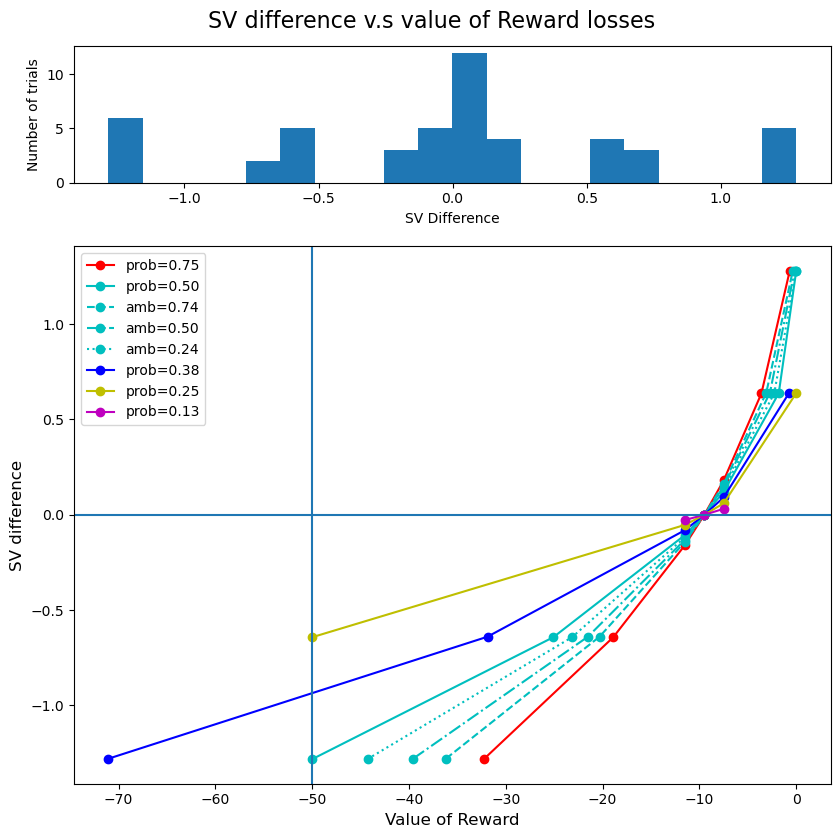

In [89]:
plot_scatter_hist(df_Trials_losses,xvline=-50,trials='losses')

# 6. Output CSV


In [90]:
df_trials = pd.concat([df_Trials_gains,df_Trials_losses], ignore_index=True)
raw_trials = 'csv/raw_trials.csv'
df_trials.to_csv(raw_trials,float_format='%.2f',index=False)
pd.read_csv(raw_trials)

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta,0.75,0.00,(40.51+0j),287.58,27.16,201.689976,85.890000
1,MaxSVdelta,0.50,0.00,(44.17+0j),220.35,21.10,134.416822,85.930000
2,MaxSVdelta,0.38,0.00,(47.48+0j),188.08,17.79,102.175295,85.900000
3,MaxSVdelta,0.50,0.24,(50+0j),171.76,15.97,85.903807,85.860000
4,MaxSVdelta,0.25,0.00,(54.21+0j),153.11,13.71,67.220851,85.890000
5,MaxSVdelta,0.13,0.00,(70.28+0j),120.84,9.13,34.971731,85.870000
6,MaxSVdelta,0.50,0.50,(71.86+0j),119.13,8.85,33.264043,85.870000
7,half_maxSV_delta,0.75,0.00,(36.63+0j),244.64,27.16,201.689976,42.950000
8,half_maxSV_delta,0.50,0.00,(38.6+0j),177.41,21.10,134.416822,42.990000
9,half_maxSV_delta,0.38,0.00,(40.41+0j),145.13,17.79,102.175295,42.950000


In [91]:
#Let's reformat to match the psychopy CSV input
crdm_trials_gains = df_Trials_gains.copy()

crdm_trials_gains['category'] = 'gain'
crdm_trials_gains = crdm_trials_gains.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_gains = crdm_trials_gains.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_gains['ambiguity'] = (crdm_trials_gains['ambiguity']*100).astype(int)
crdm_trials_gains['p_reward'] = (crdm_trials_gains['p_reward']*100).astype(int)
crdm_trials_gains = crdm_trials_gains.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_gains['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gains = crdm_trials_gains[column_order]

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_gains = crdm_trials_gains.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_gains = pd.concat([zero_ambiguity_rows, non_zero_ambiguity_rows], ignore_index=True)
crdm_trials_gains


,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain
0,9.13,100,53.480000+0.000000j,13,0,gain
1,9.13,100,32.484411+0.000000j,13,0,gain
2,9.13,100,70.280000+0.000000j,13,0,gain
3,9.13,100,34.484411+0.000000j,13,0,gain
4,9.13,100,30.484411+0.000000j,13,0,gain
5,13.71,100,17.240000+0.000000j,25,0,gain
6,13.71,100,54.210000+0.000000j,25,0,gain
7,13.71,100,34.484411+0.000000j,25,0,gain
8,13.71,100,30.484411+0.000000j,25,0,gain
9,13.71,100,44.170000+0.000000j,25,0,gain


In [92]:
# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_gains))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_gains['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_gains['crdm_lott'], 0)
crdm_trials_gains['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_gains['crdm_lott'], 0)

# Display the modified DataFrame
crdm_trials_gains


,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_lott_top,crdm_lott_bot
0,9.13,100,53.480000+0.000000j,13,0,gain,0.0000000+0.0000000j,53.480000+0.000000j
1,9.13,100,32.484411+0.000000j,13,0,gain,0.0000000+0.0000000j,32.484411+0.000000j
2,9.13,100,70.280000+0.000000j,13,0,gain,70.280000+0.000000j,0.0000000+0.0000000j
3,9.13,100,34.484411+0.000000j,13,0,gain,0.0000000+0.0000000j,34.484411+0.000000j
4,9.13,100,30.484411+0.000000j,13,0,gain,0.0000000+0.0000000j,30.484411+0.000000j
5,13.71,100,17.240000+0.000000j,25,0,gain,17.240000+0.000000j,0.0000000+0.0000000j
6,13.71,100,54.210000+0.000000j,25,0,gain,0.0000000+0.0000000j,54.210000+0.000000j
7,13.71,100,34.484411+0.000000j,25,0,gain,0.0000000+0.0000000j,34.484411+0.000000j
8,13.71,100,30.484411+0.000000j,25,0,gain,30.484411+0.000000j,0.0000000+0.0000000j
9,13.71,100,44.170000+0.000000j,25,0,gain,0.0000000+0.0000000j,44.170000+0.000000j


In [93]:

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gain = crdm_trials_gains[column_order]
crdm_trials_gain

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain
0,9.13,100,0.0000000+0.0000000j,53.480000+0.000000j,13,0,gain
1,9.13,100,0.0000000+0.0000000j,32.484411+0.000000j,13,0,gain
2,9.13,100,70.280000+0.000000j,0.0000000+0.0000000j,13,0,gain
3,9.13,100,0.0000000+0.0000000j,34.484411+0.000000j,13,0,gain
4,9.13,100,0.0000000+0.0000000j,30.484411+0.000000j,13,0,gain
5,13.71,100,17.240000+0.000000j,0.0000000+0.0000000j,25,0,gain
6,13.71,100,0.0000000+0.0000000j,54.210000+0.000000j,25,0,gain
7,13.71,100,0.0000000+0.0000000j,34.484411+0.000000j,25,0,gain
8,13.71,100,30.484411+0.000000j,0.0000000+0.0000000j,25,0,gain
9,13.71,100,0.0000000+0.0000000j,44.170000+0.000000j,25,0,gain


In [94]:
#Let's reformat to match the psychopy CSV input
crdm_trials_losses = df_Trials_losses.copy()
crdm_trials_losses = crdm_trials_losses.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_losses['category'] = 'loss'
crdm_trials_losses = crdm_trials_losses.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_losses['ambiguity'] = (crdm_trials_losses['ambiguity']*100).astype(int)
crdm_trials_losses['p_reward'] = (crdm_trials_losses['p_reward']*100).astype(int)
crdm_trials_losses = crdm_trials_losses.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_losses['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_losses = crdm_trials_losses[column_order]
#crdm_trials_losses =crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=True).reset_index(drop=True)

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_losses = crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_losses = pd.concat([zero_ambiguity_rows_loss, non_zero_ambiguity_rows_loss], ignore_index=True)




In [95]:
# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_losses))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_losses['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_losses['crdm_lott'], 0)
crdm_trials_losses['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_losses['crdm_lott'], 0)

# Display the modified DataFrame
crdm_trials_losses

,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_lott_top,crdm_lott_bot
0,-0.07,100,-11.49,13,0,loss,-11.49,0.00
1,-0.07,100,-9.49,13,0,loss,-9.49,0.00
2,-0.07,100,-7.49,13,0,loss,0.00,-7.49
3,-0.34,100,-0.00,25,0,loss,0.00,-0.00
4,-0.34,100,-11.49,25,0,loss,-11.49,0.00
5,-0.34,100,-9.49,25,0,loss,0.00,-9.49
6,-0.34,100,-7.49,25,0,loss,0.00,-7.49
7,-0.34,100,-50.00,25,0,loss,-50.00,0.00
8,-0.93,100,-9.49,38,0,loss,0.00,-9.49
9,-0.93,100,-7.49,38,0,loss,0.00,-7.49


In [96]:
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_loss = crdm_trials_losses[column_order]
crdm_trials_loss

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain
0,-0.07,100,-11.49,0.00,13,0,loss
1,-0.07,100,-9.49,0.00,13,0,loss
2,-0.07,100,0.00,-7.49,13,0,loss
3,-0.34,100,0.00,-0.00,25,0,loss
4,-0.34,100,-11.49,0.00,25,0,loss
5,-0.34,100,0.00,-9.49,25,0,loss
6,-0.34,100,0.00,-7.49,25,0,loss
7,-0.34,100,-50.00,0.00,25,0,loss
8,-0.93,100,0.00,-9.49,38,0,loss
9,-0.93,100,0.00,-7.49,38,0,loss


In [97]:
crdm_trials = pd.concat([crdm_trials_gain,crdm_trials_loss],ignore_index=True)

In [98]:
crdm_trials_csv = 'csv/crdm_trials.csv'
crdm_trials.to_csv(crdm_trials_csv,float_format='%.2f',index=False)
pd.read_csv(crdm_trials_csv)

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain
0,9.13,100,0j,(53.48+0j),13,0,gain
1,9.13,100,0j,(32.484410848700065+0j),13,0,gain
2,9.13,100,(70.28+0j),0j,13,0,gain
3,9.13,100,0j,(34.484410848700065+0j),13,0,gain
4,9.13,100,0j,(30.484410848700065+0j),13,0,gain
5,13.71,100,(17.24+0j),0j,25,0,gain
6,13.71,100,0j,(54.21+0j),25,0,gain
7,13.71,100,0j,(34.484410848700065+0j),25,0,gain
8,13.71,100,(30.484410848700065+0j),0j,25,0,gain
9,13.71,100,0j,(44.17+0j),25,0,gain


https://i.pinimg.com/736x/f3/6c/11/f36c119a1229c67741fca443fc97de6d.jpg